# SPS Specific Trade Concerns and U.S. Agricultural Exports 
Xin Ning <br>
Ph.D. Candidate <br>
*Agricultural and Applied Economics, Virginia Tech*
<br><br>
This notebook is to present some research findings based on one of my dissertation work. 
The objectives of this study are: 
1. To investigate the Sanitary and Phytosanitary (SPS) measures in terms of SPS specific trade concerns (STCs) raised/supported or maintained by WTO members to the WTO SPS Committee Meetings; 
    - Here we turn our focus on U.S. agricultural exports in major product sectors (including all meat, dairy, furits, vegetables, cereals products at the Harmonization System 6-digit level). 
2. To examine the possibly hazardous impact of SPS STCs on U.S. agricultural export durations and survivals. 
    - We start with non-parametric analysis (Kaplan Meier model), then move to semi-parametric (Cox proportional hazard model) and full parametric methods (discrete time hazard model). 
***

## 1. Description of SPS Specific Trade Concerns 


In [1]:
# load in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.tools as tls   
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import cufflinks as cf 
cf.go_offline()
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # limiting floats output to 3 decimal points
from pylab import rcParams
rcParams['figure.figsize']=12, 5

In [2]:
# load in the dataset
df_stc = pd.read_csv('sps_stc.csv')
# check missing value for Year_end 
df_stc['yr_end'] = df_stc['yr_end'].fillna(value=df_stc['yr_end'].max()).astype(int)
# df_stc.describe()
# df_stc.columns
# df_stc.shape

df_stc_kid = df_stc.drop(['hs','submtn'], axis=1)
df_stc_kid = df_stc_kid.drop_duplicates()

# keep unique STCs 
df_stc_sid = df_stc.drop(['hs','mtn','submtn','isoimp', 'isoexp', 'memr', 'mems','euimp','euexp'], axis=1)
df_stc_sid = df_stc_sid.drop_duplicates()

df_stc.info()
df_stc.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 21 columns):
stc            2973 non-null int64
isoimp         2973 non-null object
isoexp         2973 non-null object
hs             2973 non-null int64
mtn            2973 non-null object
submtn         2973 non-null object
yr_begin       2973 non-null int64
last_yr_rsd    2973 non-null int64
yr_end         2973 non-null int64
times_rsd      2973 non-null int64
years_rsd      2973 non-null int64
wto_subject    2973 non-null object
ntmtype        2973 non-null object
implemented    2973 non-null int64
dispute        2973 non-null int64
language       2973 non-null object
status         2973 non-null object
memr           2973 non-null int64
mems           2973 non-null int64
euimp          2973 non-null int64
euexp          2973 non-null int64
dtypes: int64(13), object(8)
memory usage: 487.8+ KB


,stc,isoimp,isoexp,hs,mtn,submtn,yr_begin,last_yr_rsd,yr_end,times_rsd,...,wto_subject,ntmtype,implemented,dispute,language,status,memr,mems,euimp,euexp
0,1,KOR,ARG,401,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,0,1,0,0
1,1,KOR,AUS,401,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,1,0,0,0
2,1,KOR,CAN,401,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,1,0,0,0
3,1,KOR,EUR,401,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,0,1,0,1
4,1,KOR,USA,401,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,1,0,0,0
5,1,KOR,ARG,402,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,0,1,0,0
6,1,KOR,AUS,402,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,1,0,0,0
7,1,KOR,CAN,402,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,1,0,0,0
8,1,KOR,EUR,402,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,0,1,0,1
9,1,KOR,USA,402,DAIRY,FMKP,1995,2001,1995,7,...,FS,CPCL,1,1,New regulations,PR,1,0,0,0


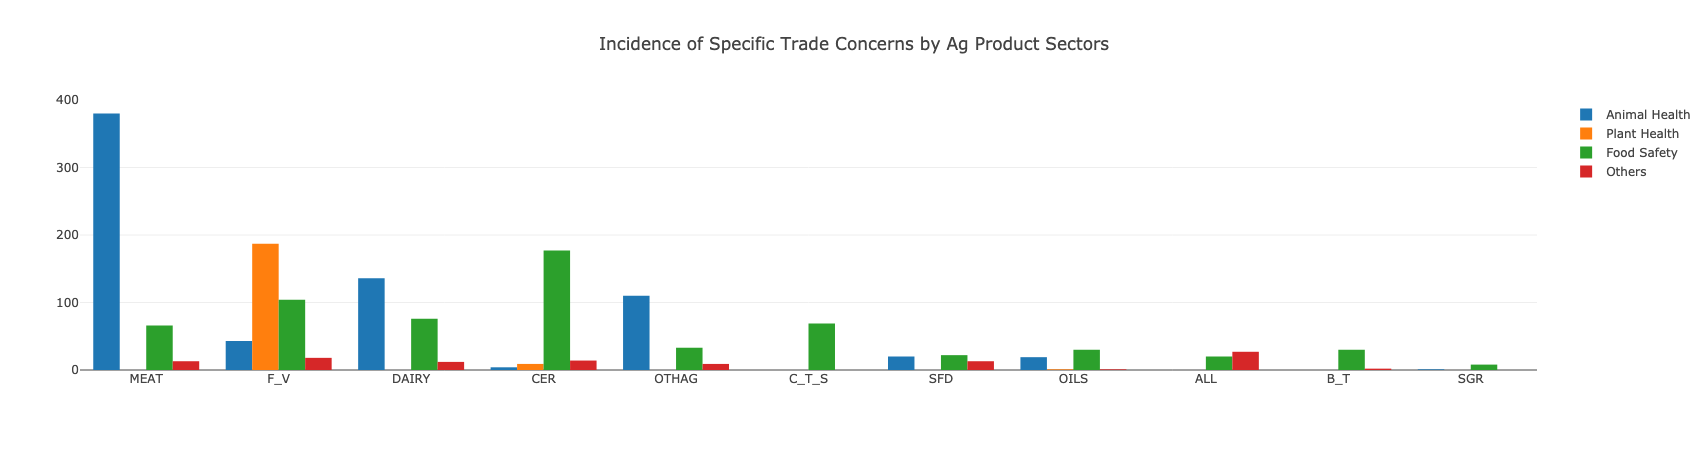

In [3]:
# tabulate times raised by year and language
stc_kid_pvt = df_stc_kid.pivot_table(index= ['mtn'], 
                       columns= ['wto_subject'], 
                       values= 'stc',
                       aggfunc='count',
                       fill_value=0)
stc_kid_pvt.columns.name = None
stc_kid_pvt = stc_kid_pvt.reset_index() 
stc_kid_pvt['total'] = stc_kid_pvt.sum(axis=1)
stc_kid_pvt.sort_values(by=['total'], ascending=False, inplace=True)

# iplot 
stc_kid_pvt_ah = go.Bar(
        x=stc_kid_pvt['mtn'],
        y=stc_kid_pvt['AH'],
        name = 'Animal Health')

stc_kid_pvt_ph = go.Bar(
        x=stc_kid_pvt['mtn'],
        y=stc_kid_pvt['PH'],
        name = 'Plant Health')

stc_kid_pvt_fs = go.Bar(
        x=stc_kid_pvt['mtn'],
        y=stc_kid_pvt['FS'],
        name = 'Food Safety')

stc_kid_pvt_oth = go.Bar(
        x=stc_kid_pvt['mtn'],
        y=stc_kid_pvt['OTH'],
        name = 'Others')

data = [stc_kid_pvt_ah, stc_kid_pvt_ph, stc_kid_pvt_fs, stc_kid_pvt_oth]

layout = go.Layout(
            barmode='group',
            title='Incidence of Specific Trade Concerns by Ag Product Sectors')

fig = go.Figure(data=data,layout=layout)
iplot(fig,filename='stc_kid_pvt_mtn')

The major concerned agricultural exports are meat, fruits, vegetables, dairy, cereals and prep products.

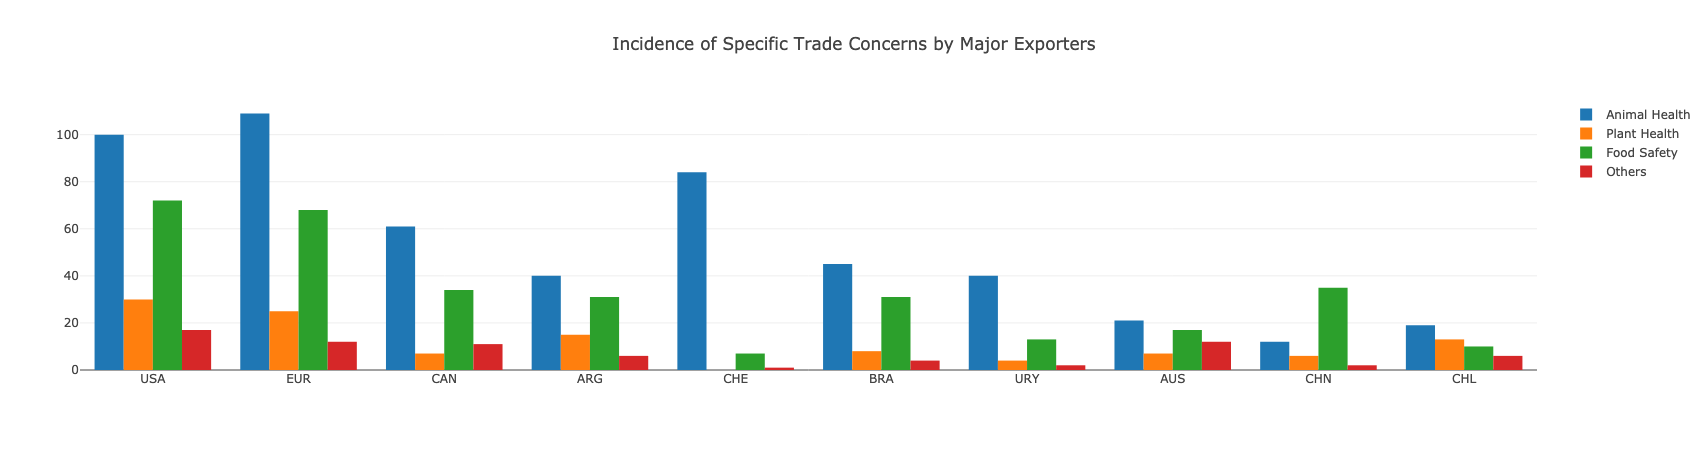

In [4]:
# tabulate times raised by year and language
stc_kid_pvt2 = df_stc_kid.pivot_table(index= ['isoexp'], 
                       columns= ['wto_subject'], 
                       values= 'stc',
                       aggfunc='count',
                       fill_value=0)
stc_kid_pvt2.columns.name = None
stc_kid_pvt2 = stc_kid_pvt2.reset_index() 
stc_kid_pvt2['total'] = stc_kid_pvt2.sum(axis=1)
stc_kid_pvt2.sort_values(by=['total'], ascending=False, inplace=True)
stc_kid_pvt2 = stc_kid_pvt2.head(10)

# iplot 
stc_kid_pvt_ah = go.Bar(
        x=stc_kid_pvt2['isoexp'],
        y=stc_kid_pvt2['AH'],
        name = 'Animal Health')

stc_kid_pvt_ph = go.Bar(
        x=stc_kid_pvt2['isoexp'],
        y=stc_kid_pvt2['PH'],
        name = 'Plant Health')

stc_kid_pvt_fs = go.Bar(
        x=stc_kid_pvt2['isoexp'],
        y=stc_kid_pvt2['FS'],
        name = 'Food Safety')

stc_kid_pvt_oth = go.Bar(
        x=stc_kid_pvt2['isoexp'],
        y=stc_kid_pvt2['OTH'],
        name = 'Others')

data = [stc_kid_pvt_ah, stc_kid_pvt_ph, stc_kid_pvt_fs, stc_kid_pvt_oth]

layout = go.Layout(
    barmode='group',
    title='Incidence of Specific Trade Concerns by Major Exporters')

fig = go.Figure(data=data,layout=layout)
iplot(fig,filename='stc_kid_pvt_isoexp')


The major concerned agricultural exporters are United States, European Union, Canada, Argentina, Brail, China.

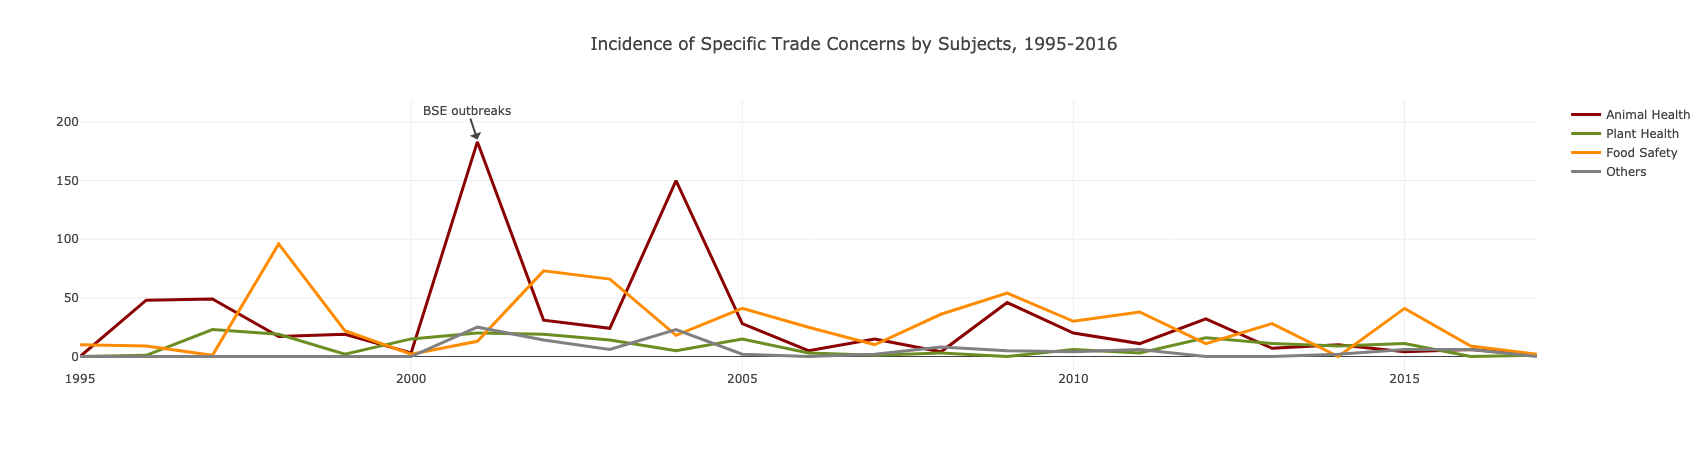

In [5]:
# tabulate times raised by year and language
stc_kid_pvt = df_stc_kid.pivot_table(index= ['yr_begin'], 
                       columns= ['wto_subject'], 
                       values= 'stc',
                       aggfunc='count',
                       fill_value=0)
stc_kid_pvt.columns.name = None
stc_kid_pvt = stc_kid_pvt.sort_values(by=['yr_begin'], ascending=False).reset_index()

# iplot 
stc_kid_pvt_ah = go.Scatter(
                x=stc_kid_pvt['yr_begin'],
                y=stc_kid_pvt['AH'],
                name = 'Animal Health',
                line = dict(color = '#8B0000',width = 3),
                opacity = 1)

stc_kid_pvt_ph = go.Scatter(
                x=stc_kid_pvt['yr_begin'],
                y=stc_kid_pvt['PH'],
                name = 'Plant Health',
                line = dict(color = '#6B8E23',width = 3),
                opacity = 1)

stc_kid_pvt_fs = go.Scatter(
                x=stc_kid_pvt['yr_begin'],
                y=stc_kid_pvt['FS'],
                name = 'Food Safety',
                line = dict(color = '#FF8C00',width = 3),
                opacity = 1)

stc_kid_pvt_oth = go.Scatter(
                x=stc_kid_pvt['yr_begin'],
                y=stc_kid_pvt['OTH'],
                name = 'Others',
                line = dict(color = '#808080',width = 3),
                opacity = 1)

data = [stc_kid_pvt_ah, stc_kid_pvt_ph, stc_kid_pvt_fs, stc_kid_pvt_oth]

layout = dict(
    title = "Incidence of Specific Trade Concerns by Subjects, 1995-2016",
    annotations=[
        dict(
        x=2001,
        y=185,
        xref='x',
        yref='y',
        text='BSE outbreaks')
    ]
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stc_kid_pvt_year')

count   1654.000
mean       6.472
std        8.550
min        1.000
25%        2.000
50%        3.000
75%        6.000
max       32.000
Name: times_rsd, dtype: float64
count   1654.000
mean       4.054
std        4.162
min        1.000
25%        1.000
50%        2.000
75%        5.000
max       21.000
Name: years_rsd, dtype: float64


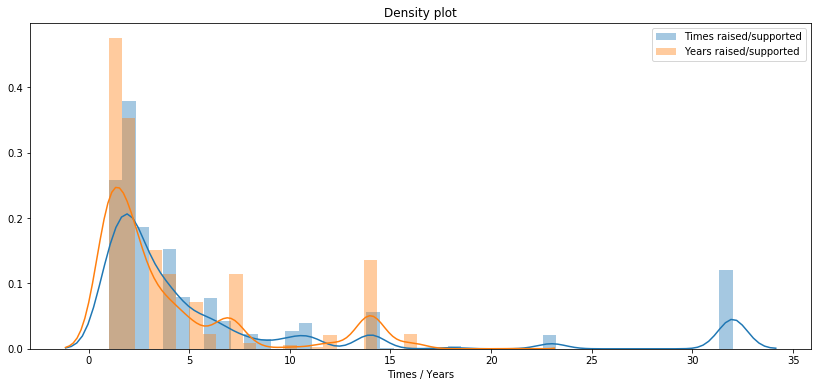

In [6]:
# describe Times raised/supported and Years raised/supported
print(df_stc_kid['times_rsd'].describe())
print(df_stc_kid['years_rsd'].describe())
# print("Skewness of Times r/s of STCs: %f" % df_stc_sid['times_rsd'].skew())
# print("Kurtosis of Times r/s of STCs: %f" % df_stc_sid['times_rsd'].kurt())
# print("Skewness of Years r/s of STCs: %f" % df_stc_sid['years_rsd'].skew())
# print("Kurtosis of Years r/s of STCs: %f" % df_stc_sid['years_rsd'].kurt())

plt.figure(figsize=(14,6))
sns.distplot(df_stc_kid['times_rsd'],label='Times raised/supported')
sns.distplot(df_stc_kid['years_rsd'],label='Years raised/supported').set(xlabel='Times / Years', ylabel='',title='Density plot')
plt.legend()
plt.show()
# scatter plot of Years and Times r/s
# sns.jointplot(x='times_rsd',y='years_rsd',data=df_stc_kid,kind='reg')
# sns.pairplot(df_stc_sid[['times_rsd','years_rsd']])
# sns.lmplot(x='times_rsd',y='years_rsd',data=df_stc_kid,col='wto_subject')

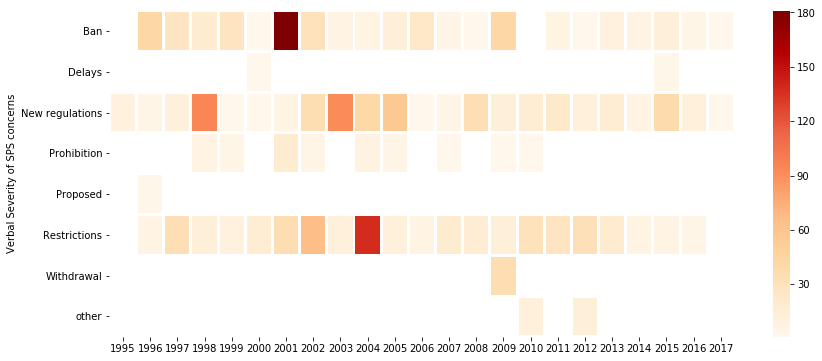

In [7]:
# language used for raising/supporting STCs 
plt.figure(figsize=(14,6))
stc_kid_lang = df_stc_kid.pivot_table(index= 'language', columns= 'yr_begin', values= "stc",aggfunc='count')
sns.heatmap(stc_kid_lang,cmap='OrRd',linecolor='white',linewidths=2).\
            set(xlabel='', ylabel='Verbal Severity of SPS concerns')
plt.show()

In [8]:
# load data at HS 6-digit product level, keep only MEAT, F_V, DAIRY, & CER 
df_stc_usa = pd.read_csv('sps_stc_usa.csv')
df_stc_usaexp = df_stc_usa[(df_stc_usa['isoexp']=='USA') & ((df_stc_usa['mtn']=='MEAT') | (df_stc_usa['mtn']=='F_V') | (df_stc_usa['mtn']=='DAIRY') | (df_stc_usa['mtn']=='CER') )]
# df_stc_usaexp.head(10)

# plt.figure(figsize=(14,6))
# sns.countplot(x='mtn',hue="wto_subject",data=df_stc_usaexp,order = df_stc_usaexp['mtn'].value_counts().iloc[:10].index)
# plt.show()

<br> <br> 
## 2. Descriptions of US Agricultural Exports 

In [9]:
# load TRADE data for sectors = MEAT, F_V, DAIRY, CER
df_trade_usaexp = pd.read_csv('usa_exp_topmtn_hs6_bv10.csv')
print(df_trade_usaexp.columns)
df_trade_usaexp.head()

Index(['isoimp', 'isoexp', 'hs6', 'year', 'flow', 'mtn', 'trade_dur',
       'trade_spell', 'trade_end', 'trade_rightc', 'trade_leftcid', 'tar',
       'lntar', 'lv10', 'id', 'ct_jkt', 'ishr_imp', 'hhi_imp', 'rta_n', 'dist',
       'contig', 'lang', 'colony', 'ldist', 'gdp_imp', 'pop_imp', 'lgdp_imp',
       'regimp', 'agregimp', 'gdp_exp', 'pop_exp', 'lgdp_exp', 'regexp',
       'agregexp', 'exch_chg', 'dev_imf_impj', 'dev_imf_expi', 'impinc',
       'expinc', 'rank_imp', 'rank_imp2', 'euimp', 'euexp', 'importer',
       'exporter'],
      dtype='object')


,isoimp,isoexp,hs6,year,flow,mtn,trade_dur,trade_spell,trade_end,trade_rightc,...,dev_imf_impj,dev_imf_expi,impinc,expinc,rank_imp,rank_imp2,euimp,euexp,importer,exporter
0,GBR,USA,10111,1995,74825.023,MEAT,1,1,0,0,...,1,1,High income,High income,1,3,1,0,United Kingdom,United States
1,GBR,USA,10111,1996,47909.039,MEAT,2,1,0,0,...,1,1,High income,High income,1,3,1,0,United Kingdom,United States
2,GBR,USA,10111,1997,68348.102,MEAT,3,1,0,0,...,1,1,High income,High income,1,3,1,0,United Kingdom,United States
3,GBR,USA,10111,1998,65706.539,MEAT,4,1,0,0,...,1,1,High income,High income,1,3,1,0,United Kingdom,United States
4,GBR,USA,10111,1999,51635.695,MEAT,5,1,0,0,...,1,1,High income,High income,1,3,1,0,United Kingdom,United States


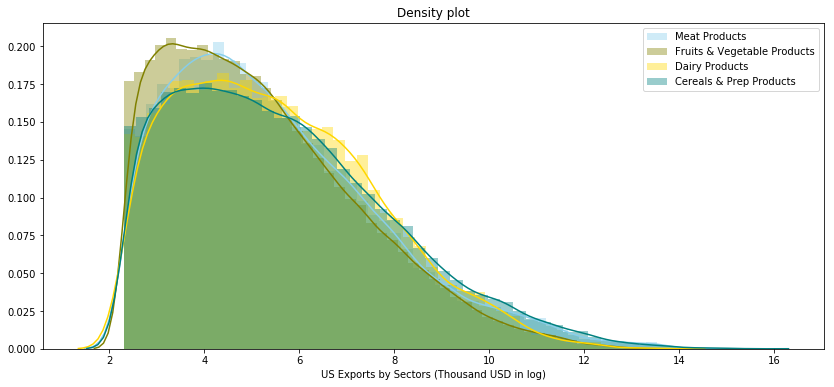

In [10]:
# keep positive trade, then generate log of flow 
trade_usaexp_pos = df_trade_usaexp[(df_trade_usaexp['flow']>0)]
trade_usaexp_pos['lflow'] = np.log(trade_usaexp_pos['flow'])

# density plot of trade flows 
trade_usaexp_meat = trade_usaexp_pos[(trade_usaexp_pos['mtn']=="MEAT")]
trade_usaexp_fv = trade_usaexp_pos[(trade_usaexp_pos['mtn']=="F_V")]
trade_usaexp_dairy = trade_usaexp_pos[(trade_usaexp_pos['mtn']=="DAIRY")]
trade_usaexp_cer = trade_usaexp_pos[(trade_usaexp_pos['mtn']=="CER")]

# plt.figure(figsize=(14,6))
# sns.distplot( trade_usaexp_meat['flow'] , color="skyblue", label='Meat Products')
# sns.distplot( trade_usaexp_fv['flow'] , color="olive", label='Fruits & Vegetable Products')
# sns.distplot( trade_usaexp_dairy['flow'] , color="gold", label='Dairy Products')
# sns.distplot( trade_usaexp_cer['flow'] , color="teal", label='Cereals & Prep Products').set(xlabel='US Exports by Sectors (Thousand USD in log)', ylabel='',title='Density plot')
# plt.legend()
# plt.show()

plt.figure(figsize=(14,6))
sns.distplot( trade_usaexp_meat['lflow'] , color="skyblue", label='Meat Products')
sns.distplot( trade_usaexp_fv['lflow'] , color="olive", label='Fruits & Vegetable Products')
sns.distplot( trade_usaexp_dairy['lflow'] , color="gold", label='Dairy Products')
sns.distplot( trade_usaexp_cer['lflow'] , color="teal", label='Cereals & Prep Products').set(xlabel='US Exports by Sectors (Thousand USD in log)', ylabel='',title='Density plot')
plt.legend()
plt.show()

In [11]:
# trade map data 
trade_map = trade_usaexp_pos.pivot_table(index= ['isoimp', 'importer'], columns= ['mtn','year'], values= "flow",aggfunc='sum')/1000
trade_map.columns = trade_map.columns.map('{0[0]}_{0[1]}'.format)
trade_map = trade_map.reset_index()
# print(trade_map.columns)

In [12]:
# sectorlist = trade_map.columns.get_values().tolist()
sector = input("Which product sector & year to display? ") 
print("You have chosen " + sector + "!")
# MEAT_2016, F_V_2016, DAIRY_2016, CER_2016

Which product sector & year to display? MEAT_2015
You have chosen MEAT_2015!


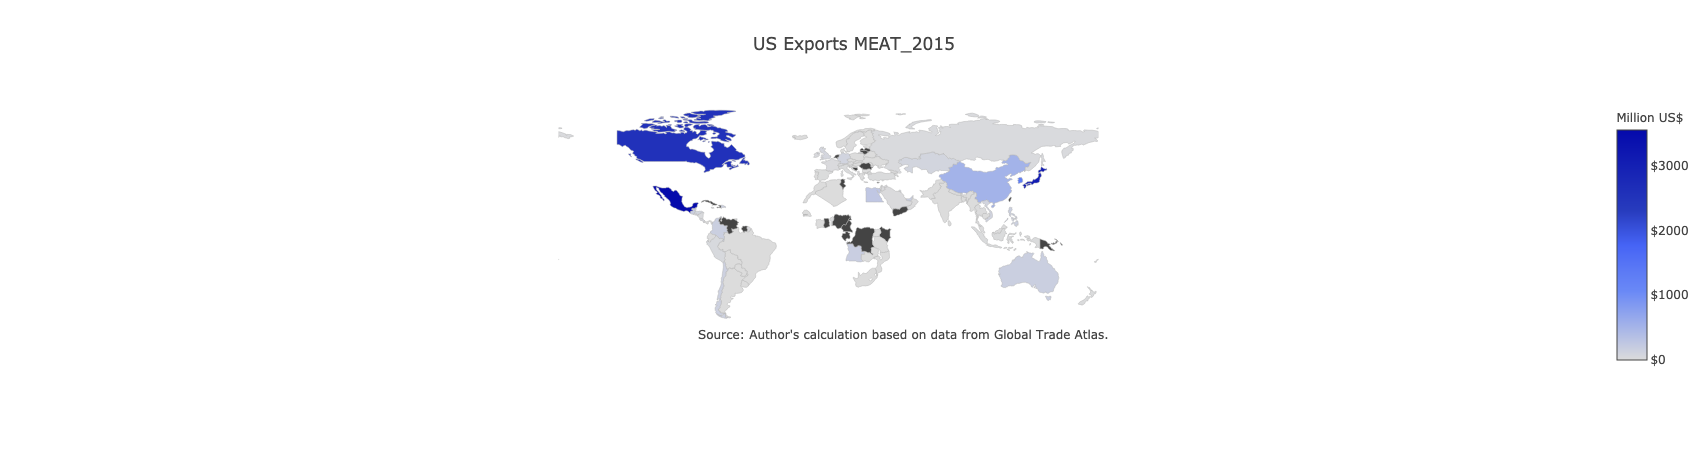

In [13]:
# trade map frame 
data = [go.Choropleth(
    locations = trade_map['isoimp'],
    z = trade_map[sector],        
    text = trade_map['importer'],
    colorscale = 'Blues',
    autocolorscale = False,
    reversescale = True,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 0.5
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = '$',
        title = 'Million US$'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = 'US Exports '+sector
    ),
    geo = go.layout.Geo(
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = "Source: Author's calculation based on data from Global Trade Atlas.",
        showarrow = False
    )]
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'us-meat-export-world-map')

<br> <br> 
## 3. Survival Analysis of US Agricultural Exports 

Index(['isoimp', 'isoexp', 'hs6', 'year', 'flow', 'mtn', 'trade_dur',
       'trade_spell', 'trade_end', 'trade_rightc', 'trade_leftcid', 'tar',
       'lntar', 'lv10', 'id', 'ct_jkt', 'ishr_imp', 'hhi_imp', 'rta_n', 'dist',
       'contig', 'lang', 'colony', 'ldist', 'gdp_imp', 'pop_imp', 'lgdp_imp',
       'regimp', 'agregimp', 'gdp_exp', 'pop_exp', 'lgdp_exp', 'regexp',
       'agregexp', 'exch_chg', 'dev_imf_impj', 'dev_imf_expi', 'impinc',
       'expinc', 'rank_imp', 'rank_imp2', 'euimp', 'euexp', 'importer',
       'exporter', 'times_rsd', 'years_rsd', 'implemented', 'dispute',
       'language', 'wto_subject', 'ntmtype', 'sps', 'sps_n'],
      dtype='object')


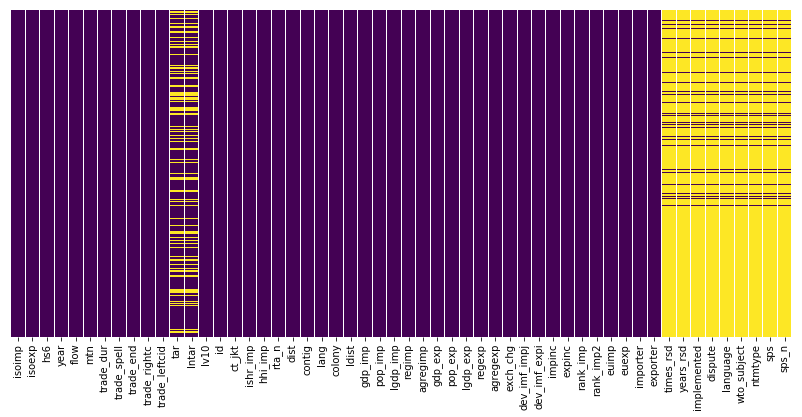

In [14]:
# merge STC data with TRADE data 
df_trade_stc = pd.merge(df_trade_usaexp,df_stc_usaexp,how='left',on=['isoimp','isoexp','hs6','mtn','year'])
# print(df_trade_stc.shape)
# df_trade_stc.info()
# df_trade_stc

trade_stc_pos = df_trade_stc[(df_trade_stc['trade_dur']>0)]
print(trade_stc_pos.columns)

# check missing data 
plt.figure(figsize=(14,6))
sns.heatmap(trade_stc_pos.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

In [15]:
# filling missing STC numeric variables
num_columns = ['times_rsd','years_rsd','implemented','dispute','sps','sps_n']
trade_stc_pos[num_columns] = trade_stc_pos[num_columns].fillna(0)
trade_stc_pos['ct_stc'] = trade_stc_pos[['isoimp','hs6','sps']].groupby(['isoimp','hs6']).transform('sum')
trade_stc_pos[['times_rsd','years_rsd','implemented','dispute','sps','sps_n','ct_stc']] = trade_stc_pos[['times_rsd','years_rsd','implemented','dispute','sps','sps_n','ct_stc']].astype(int)

In [16]:
# frequence of STCs by sectors 
tab = pd.crosstab(trade_stc_pos['mtn'],trade_stc_pos['sps']).apply(lambda r: r/r.sum()*100, axis=1)
print(tab, '\n')

selector = ['impinc','regimp','euimp']
for s in selector: 
    tab = pd.crosstab(trade_stc_pos[s],trade_stc_pos['sps']).apply(lambda r: r/r.sum()*100, axis=1)
    print(tab, '\n')

sps        0      1
mtn                
CER   96.394  3.606
DAIRY 84.034 15.966
F_V   90.090  9.910
MEAT  93.078  6.922 

sps                       0      1
impinc                            
High income          86.183 13.817
Low income          100.000  0.000
Lower middle income  98.419  1.581
Upper middle income  98.331  1.669 

sps             0      1
regimp                  
AUNZ       96.733  3.267
Africa    100.000  0.000
CentralAm  99.745  0.255
CentralAs 100.000  0.000
EastAs     89.802 10.198
EastEur    96.027  3.973
NorthAm    99.685  0.315
NorthEur   70.345 29.655
SouthAm    98.131  1.869
SouthAs    96.382  3.618
SouthEur   66.350 33.650
WestAs     99.021  0.979
WestEur    70.314 29.686 

sps        0      1
euimp              
0     97.495  2.505
1     68.547 31.453 



In [17]:
# prepare data, drop right censored obs (year==2016)
df_surv = trade_stc_pos[(trade_stc_pos['trade_rightc']==0)]
df_surv['hs6'] = df_surv['hs6'].astype(str).apply(lambda x: x.zfill(6))
df_surv['id'] = df_surv[['isoimp', 'isoexp', 'hs6']].apply(lambda x: '_'.join(x), axis=1).astype('category')
# df_surv.dtypes
cat_columns = df_surv.select_dtypes(['category']).columns
df_surv[cat_columns] = df_surv[cat_columns].apply(lambda x: x.cat.codes)
df_surv.head()

,isoimp,isoexp,hs6,year,flow,mtn,trade_dur,trade_spell,trade_end,trade_rightc,...,times_rsd,years_rsd,implemented,dispute,language,wto_subject,ntmtype,sps,sps_n,ct_stc
0,GBR,USA,010111,1995,74825.023,MEAT,1,1,0,0,...,0,0,0,0,NaN,NaN,NaN,0,0,0
1,GBR,USA,010111,1996,47909.039,MEAT,2,1,0,0,...,0,0,0,0,NaN,NaN,NaN,0,0,0
2,GBR,USA,010111,1997,68348.102,MEAT,3,1,0,0,...,0,0,0,0,NaN,NaN,NaN,0,0,0
3,GBR,USA,010111,1998,65706.539,MEAT,4,1,0,0,...,0,0,0,0,NaN,NaN,NaN,0,0,0
4,GBR,USA,010111,1999,51635.695,MEAT,5,1,0,0,...,0,0,0,0,NaN,NaN,NaN,0,0,0


### 3.1 Kaplan Meier Analysis 

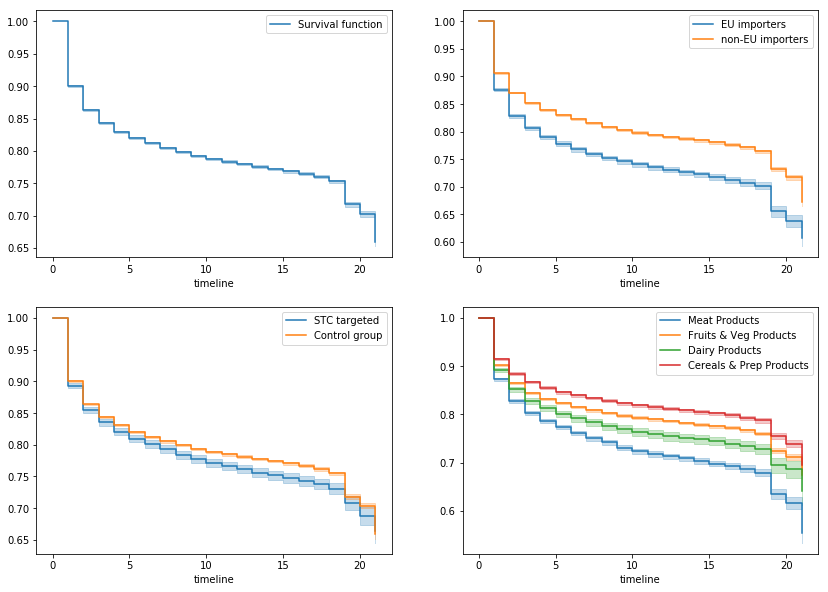

In [18]:
# survival analysis, non-parametric methods 
import lifelines as ll
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# drop right censored obs 
T = df_surv['trade_dur']
E = df_surv['trade_end']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.plot_survival_function(ax=axes[0][0],label='Survival function') 

# survival by EU importers 
groups = trade_stc_pos['euimp']
geuy = (groups == 1)
geun = (groups == 0)

kmf.fit(T[geuy], E[geuy])
kmf.plot_survival_function(ax=axes[0][1],label='EU importers') 
kmf.fit(T[geun], E[geun])
kmf.plot_survival_function(ax=axes[0][1],label='non-EU importers') 

# survival by SPS STC incidence 
groups = trade_stc_pos['sps']
gy = (groups == 1)

kmf.fit(T[gy], E[gy])
kmf.plot_survival_function(ax=axes[1][0],label='STC targeted') 
kmf.fit(T[~gy], E[~gy])
kmf.plot_survival_function(ax=axes[1][0],label='Control group') 

# survival by product sectors 
groups = trade_stc_pos['mtn']
gm = (groups == 'MEAT')
gf = (groups == 'F_V')
gd = (groups == 'DAIRY')
gc = (groups == 'CER')

kmf.fit(T[gm], E[gm])
kmf.plot_survival_function(ax=axes[1][1],label='Meat Products') 
kmf.fit(T[gf], E[gf])
kmf.plot_survival_function(ax=axes[1][1],label='Fruits & Veg Products') 
kmf.fit(T[gd], E[gd])
kmf.plot_survival_function(ax=axes[1][1],label='Dairy Products') 
kmf.fit(T[gc], E[gc])
kmf.plot_survival_function(ax=axes[1][1],label='Cereals & Prep Products') 
plt.show()

Key points to hightlight: 
- U.S. major agricultural exports raised/supported as SPS specific trade concerns are less likely to survive compared with those not exposed to concerns (plot in left bottom).
- U.S. major agricultural exports shipped to EU markets are less likely to survive compared with those shipped to non EU markets (plot in right top). 
- U.S. meat product exports are the least likely to survive compared with other products (plot in right bottom). 

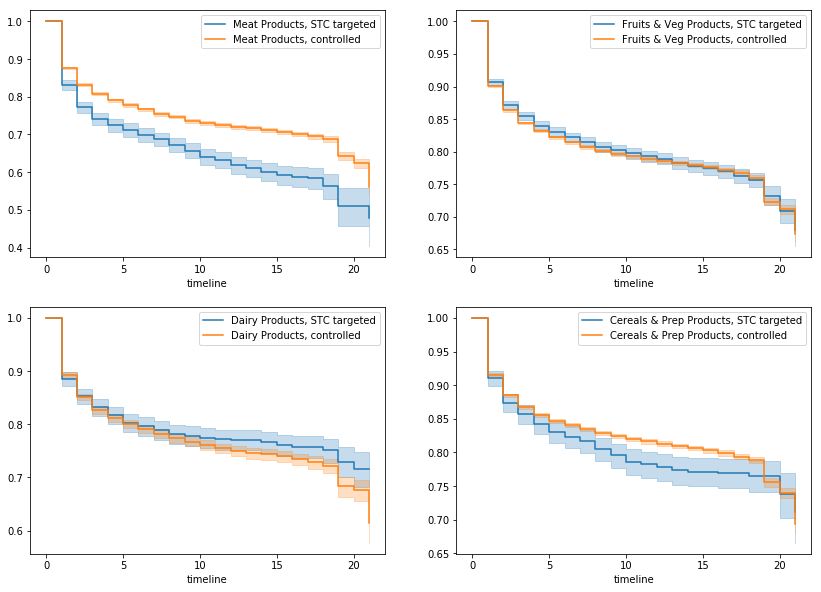

In [19]:
# survival analysis, non-parametric methods 
import lifelines as ll
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# survival by SPS STC incidence 
groups = df_surv['sps']
mtns = df_surv['mtn']
gmy = ((mtns == 'MEAT') & (groups == 1))
gmn = ((mtns == 'MEAT') & (groups == 0))
gfy = ((mtns == 'F_V') & (groups == 1))
gfn = ((mtns == 'F_V') & (groups == 0))
gdy = ((mtns == 'DAIRY') & (groups == 1))
gdn = ((mtns == 'DAIRY') & (groups == 0))
gcy = ((mtns == 'CER') & (groups == 1))
gcn = ((mtns == 'CER') & (groups == 0))

kmf.fit(T[gmy], E[gmy])
kmf.plot_survival_function(ax=axes[0][0],label='Meat Products, STC targeted') 
kmf.fit(T[gmn], E[gmn])
kmf.plot_survival_function(ax=axes[0][0],label='Meat Products, controlled') 

kmf.fit(T[gfy], E[gfy])
kmf.plot_survival_function(ax=axes[0][1],label='Fruits & Veg Products, STC targeted') 
kmf.fit(T[gfn], E[gfn])
kmf.plot_survival_function(ax=axes[0][1],label='Fruits & Veg Products, controlled') 

kmf.fit(T[gdy], E[gdy])
kmf.plot_survival_function(ax=axes[1][0],label='Dairy Products, STC targeted') 
kmf.fit(T[gdn], E[gdn])
kmf.plot_survival_function(ax=axes[1][0],label='Dairy Products, controlled') 

kmf.fit(T[gcy], E[gcy])
kmf.plot_survival_function(ax=axes[1][1],label='Cereals & Prep Products, STC targeted') 
kmf.fit(T[gcn], E[gcn])
kmf.plot_survival_function(ax=axes[1][1],label='Cereals & Prep Products, controlled') 
plt.show()

The hazardous impact of SPS STCs are more pronounced for Meat and Cereals & Prep exports. 

In [20]:
# testing for difference (STC-targeted vs non-targeted)
from lifelines.statistics import logrank_test

results= logrank_test(T[gy], T[~gy], E[gy], E[~gy], alpha=95)
results.print_summary()
print('Estimated p-value is ',round(results.p_value, 3))

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 95

---
test_statistic      p  -log2(p)
         22.42 <0.005     18.80
Estimated p-value is  0.0


We reject the null hypothesis, implying that there is a significant difference in trade survivals between STC-targeted trade flows and non-targeted ones.

### 3.2 Cox Proportional Hazard Model  

In [21]:
# survival regression analysis, semi-parametric models
from lifelines import CoxPHFitter
cph = CoxPHFitter()

cph_data = df_surv[['trade_dur','trade_spell','trade_end',
                    'rta_n','contig','lang','colony','sps']]

cph.fit(cph_data, 'trade_dur','trade_end', show_progress=False, robust=True)
cph.print_summary()
# cph.print_summary(model="untransformed variables", decimals=3)
# cph.predict_median(cph_data)

In [ ]:
# <lifelines.CoxPHFitter: fitted with 247129 observations, 200493 censored> 
#       duration col = 'trade_dur' 
#          event col = 'trade_end' 
#    robust variance = True 
# number of subjects = 247129 
#   number of events = 46636 
#     log-likelihood = -553176.752 
#   time fit was run = 2019-04-11 20:38:22 UTC 
#              model = untransformed variables 
# 
# 
# ---
#               coef exp(coef)  se(coef)       z       p  -log2(p)  lower 0.95  upper 0.95 
# trade_spell  0.454     1.574     0.004 126.694 <0.0005       inf       0.446       0.461 
# rta_n       -0.683     0.505     0.016 -42.931 <0.0005       inf      -0.714      -0.652 
# contig      -1.371     0.254     0.054 -25.333 <0.0005   467.930      -1.478      -1.265 
# lang        -0.171     0.843     0.011 -15.168 <0.0005   170.219      -0.193      -0.149 
# colony      -0.296     0.744     0.022 -13.628 <0.0005   138.066      -0.339      -0.254 
# sps         -0.050     0.951     0.017  -3.011   0.003     8.586      -0.082      -0.017 
# ---
# Concordance = 0.671 
# Log-likelihood ratio test = 17362.386 on 6 df, -log2(p)=inf 


In [22]:
# model selection 
from lifelines import AalenAdditiveFitter, CoxPHFitter
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

df = df_surv[['flow','trade_dur','trade_end']]

#create the three models we'd like to compare.
aaf_1 = AalenAdditiveFitter(coef_penalizer=0.5)
aaf_2 = AalenAdditiveFitter(coef_penalizer=10)
cph = CoxPHFitter()

print(np.mean(k_fold_cross_validation(cph, df, duration_col='trade_dur', event_col='trade_end')))
print(np.mean(k_fold_cross_validation(aaf_1, df, duration_col='trade_dur', event_col='trade_end')))
print(np.mean(k_fold_cross_validation(aaf_2, df, duration_col='trade_dur', event_col='trade_end')))

0.8016816383640256
0.8016845698612359
0.8016784368902166


In [23]:
# convert categorical variable into dummies 
# dum = pd.get_dummies(df_train,drop_first=True)
# df_train = pd.concat([df_train,dum],axis=1)


### 3.3 Discrete-Time Hazard Model 

Let $T$ be a non-negative random variable that measures the survival time of the $i$th trade relationship, i.e., an exporting country (in our analysis, the U.S.) exports a specific product to a specific importing country at time $t$, also noted as an exporter-importer-HS6 triplet. The conditional probability that the $i$th trade relationship ends at time $t+1$ conditional on the relationship surviving up to the time $t$, also termed as the discrete time hazard rate, $h_{it}$, is specified as,

\begin{align*}
h_{it} = P(T_{i} \leq t+1 | T_{i} \geq t) = \Phi(\bf{x_{it}}\beta + {\gamma}_t)
\end{align*}

where $\bf{x_{it}}$ is a set of time-varying explanatory variates, $\beta$ is the estimated coefficients, ${\gamma}_t$ is a set of dummy variables identifying the duration of each spell in order to allow the hazard rate to vary across periods, and $\Phi(\cdot)$ is an appropriate distribution function that ensures $0 \leq h_{it} \leq 1$. 

Let $y_{it}$ be a dummy variable that is equal to one if the $i$th trade spell was observed to end during the $t$th time interval, and zero otherwise, the log-likelihood function for the discrete time duration model is then defined as, 

\begin{align*}
\ln L = \sum_{i} \sum_{t} (y_{it}* \ln (h_{it})) + (1-y_{it}) * \ln (1-h_{it}) 
\end{align*}

Empirically, our discrete-time hazard function for U.S. agricultural exports is specified as, 

\begin{align*}
y_{it} &= \beta_{1}DUR_{i} + \beta_{2}LEFT_{i} + \beta_{3}DUR_{it} * LEFT_{i} + \sum_{s}\gamma_{s}SPELL_{is} + \\  
       &  \quad \beta_{4}TAR_{it} + \beta_{5}ER_{it} + \beta_{6}EXPR_{it} + \sum_{m}\delta_{m}GRAV_{i} + \\ 
       & \quad \alpha_{1}STC_{it} + \lambda_{i} + \lambda_{t} + \varepsilon_{it}
\end{align*}



### Here I present the table of results using the discrete-time hazard model. 

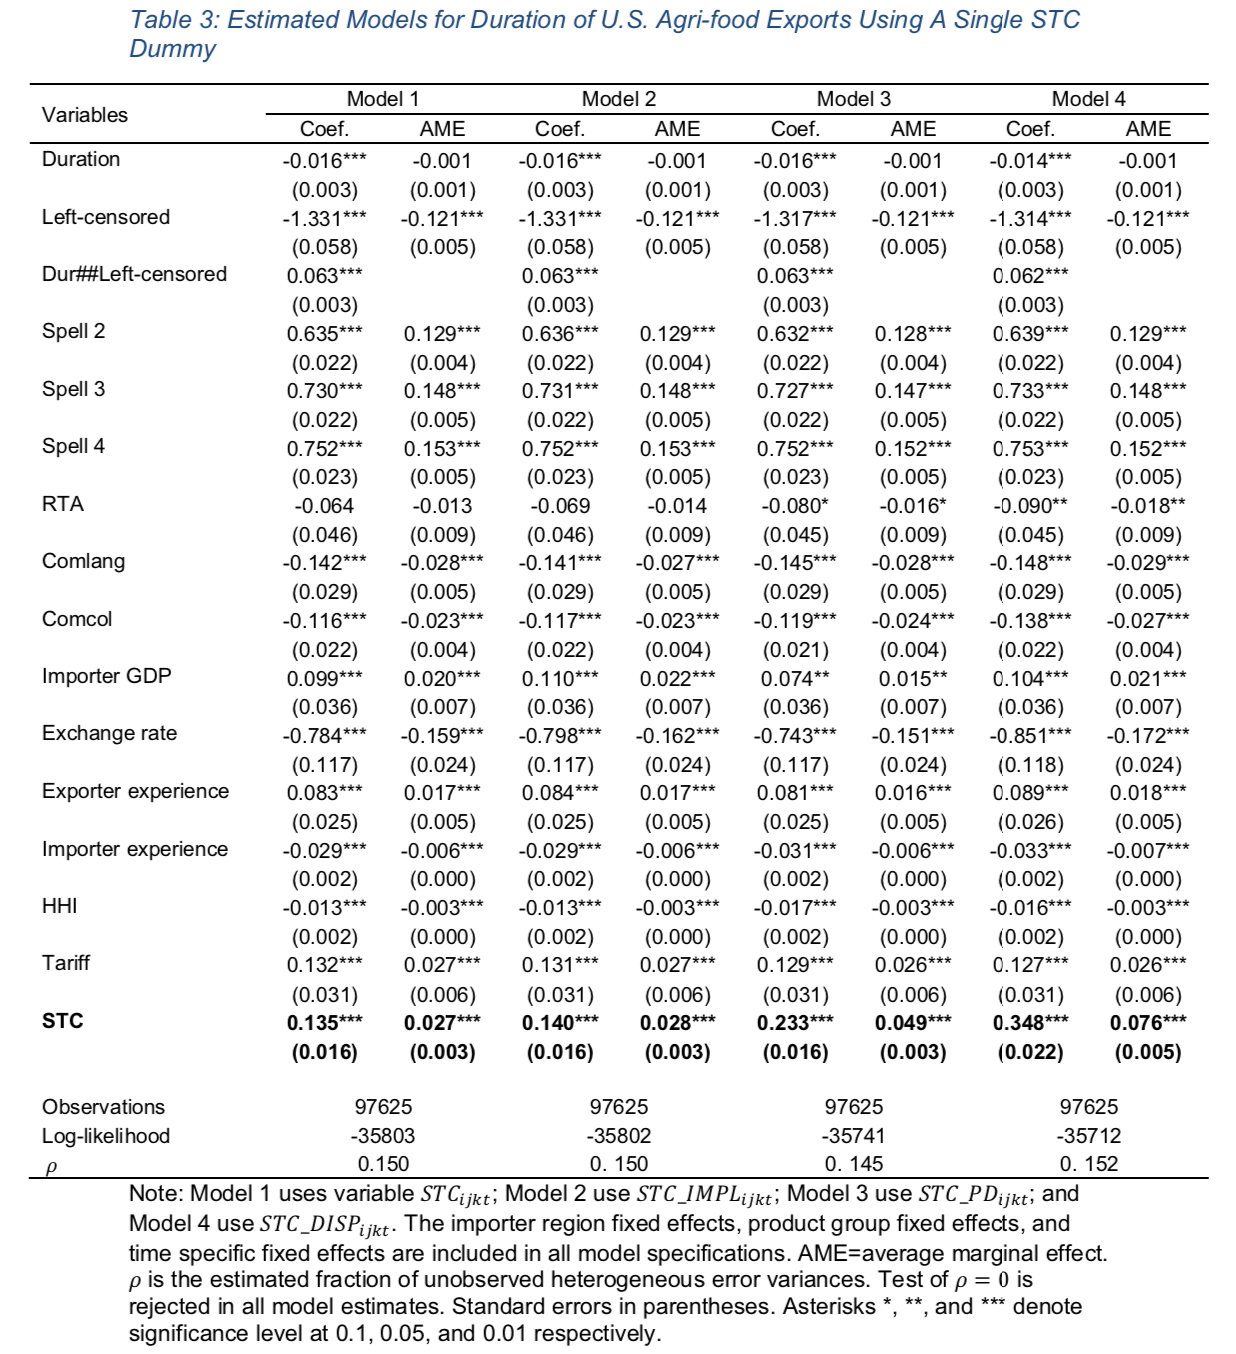

In [3]:
from IPython.display import Image
Image(filename='discrete-time-hazard-mrs.png',width=800) 
# ![title](img/discrete-time-hazard-mrs.png)